## Function to create a list with all the file paths within a path

In [21]:
def getFilePaths(path):
    # Function to return a list of files in a path:
    # Initialize a list for all the file names
    files = list()
    # Look for folders in the list
    for file in os.listdir(path):
        # Concatenate a path for each file
        pathfile = os.path.join(path, file)
        # Validate if the pathfile is a folder
        if os.path.isdir(pathfile):
            # If it is a folder, get the paths of each folder
            files = files + getFilePaths(pathfile)
        else:
            # If it is not a folder add the path to the list
            files.append(pathfile)
    return files      

## Create a dataframe with the list of paths

In [22]:
# Import dependencies
import pandas as pd, time, hashlib

In [23]:
# Path with the files to look for duplicates
path='../1'

In [24]:
# Initialize and empty dataframe with the paths of the files in the given path
files_df = pd.DataFrame(getFilePaths(path),columns=['path'])
# Initialize Columns for the dataframe 
files_df['hash'] = 0
files_df['filename'] = ''
files_df['count'] = 1
files_df['created'] = 0
files_df['modified'] = 0
files_df['filesize'] = 0

# Loop to fill the dataframe columns with values
for row in range(len(files_df)):
    # Load the file
    image_file = open(files_df['path'][row],'rb').read()
    # Encode the file to a hexagsimal number
    files_df['hash'][row] = hashlib.md5(image_file).hexdigest()
    # Get the filename of the file
    files_df['filename'][row] = os.path.basename(files_df['path'][row])
    # Get the created date 
    files_df['created'][row] = pd.to_datetime(time.ctime(os.path.getctime(files_df['path'][row])))
    # Get the modified date 
    files_df['modified'][row] = pd.to_datetime(time.ctime(os.path.getmtime(files_df['path'][row])))
    # Get file size
    files_df['filesize'][row] = os.path.getsize(files_df['path'][row])
# Print first rows of the dataframe    
files_df.head()

path  \
0  ../1/639a58cd-e467-4187-91fe-35c71cc86970.jpg   
1  ../1/634fb9e9-4ca6-4ff3-a2d2-4ee81cfbde85.jpg   
2  ../1/92f5ab2f-15b2-4175-a08d-06c7f66c0e28.jpg   
3                                 ../1/.DS_Store   
4  ../1/37f16d12-a798-49a9-a145-e04c167e54c0.jpg   

                               hash                                  filename  \
0  374f0604be4b276c023e330f409d2a7b  639a58cd-e467-4187-91fe-35c71cc86970.jpg   
1  4d0c606b822f16e97762a413b3e102c6  634fb9e9-4ca6-4ff3-a2d2-4ee81cfbde85.jpg   
2  07f63c2ed334d6e3c31d13f4030156ed  92f5ab2f-15b2-4175-a08d-06c7f66c0e28.jpg   
3  d13c0d46e5380fa87709e82d34a48bf5                                 .DS_Store   
4  afd165573dd62113bdbf71311cbb503f  37f16d12-a798-49a9-a145-e04c167e54c0.jpg   

   count              created             modified  filesize  
0      1  2020-04-10 21:19:46  2020-04-08 19:08:52     45155  
1      1  2020-04-10 21:19:46  2020-04-07 11:34:38    158673  
2      1  2020-04-10 21:19:46  2020-04-07 15:13:26    201558  
3      1  2020-04-10 21:20:10  2020-04-10 21:20:10      6148  
4      1  2020-04-10 21:19:46  2020-04-07 15:13:46    180526

## Summary of the total repeated files

In [25]:
# Import dependencies
import numpy as np, datetime

In [26]:
# Group repeated files by hash and summarize them
reapeated_files_df = files_df.groupby('hash').sum()
# Filter only files that are repeated - hash with more than 1 file
reapeated_files_df = reapeated_files_df[reapeated_files_df['count'] > 1]
# Summarize in a pivot table to have a total
pivot_df = pd.pivot_table(reapeated_files_df, values='count', index=['hash'], aggfunc=np.sum, margins=True)
# Create a unique identifier for the file name with the date and time
now_string = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
# Export the file to a csv file for furure reference
pivot_df.to_csv(now_string + ' - Duplicated' +  '.csv' )
# Visualize the result
pivot_df

count
hash                                   
135a0a7b2f5eece7ce53c6fbb26e9cd9      3
374f0604be4b276c023e330f409d2a7b      3
4d0c606b822f16e97762a413b3e102c6      3
74198ac70368792400a3a1a0900cc769      3
933827ccd64bd5345025069ddc79451f      4
b777dfc6904cee5e244c9da08bc84613      2
ef8cab05963a17a03072be7fdfe7daeb      2
All                                  20

## List of all the files and the action to be taken for each

In [27]:
# Validate if there are repeated files
if pivot_df['count']['All'] ==0:
    # If not repeated files, notify user
    print('No repeated files were found')
else:
    # If there are repeated files
    # Filter only files that are repeated, taken from the previous table summary
    repeated_path_df = files_df[files_df['hash'].isin(pivot_df.index.to_list())]
    # Group and sort rows by hash, path, created date, modified date and file size
    # Ascending sorting for all columns except for file size. We want the biggest file (more detail)
    repeated_path_df = repeated_path_df.groupby(['hash','path','created','modified','filesize']).sum().sort_values(by=['hash',                                                          'created','modified', 'filesize'],  ascending=[True, True, True, False])
    # Initialize a column for the data frame to store the action for each file (keep/delete)    
    repeated_path_df['action'] = ''
    # Specify the action (keep) for the first row
    repeated_path_df['action'][0] = 'keep' 
    # Keep the first file (earliest created and modified date and the biggest filesize) for every hash and delete the next ones
    for i in range(1,len(repeated_path_df.index.get_level_values(1).tolist())):
        if repeated_path_df.index.get_level_values(0)[i] == repeated_path_df.index.get_level_values(0)[i-1]:
            # If the hash is the same as the previous row, delete it (Keep only the first one)
            repeated_path_df['action'][i] = 'delete' 
        else:
            # if hash changes compared to the last row, keep the file (don't delete it)
            repeated_path_df['action'][i] = 'Keep'
            # Store the file in a csv file with a unique identifier with date and time 
    repeated_path_df.to_csv(now_string + ' - Duplicated - Detail'  + '.csv' )
repeated_path_df     

count  \
hash                             path                                               created             modified            filesize          
135a0a7b2f5eece7ce53c6fbb26e9cd9 ../1/7612e4ee-b49a-46d2-94d9-fbc234c71b2e.jpg      2020-04-10 21:19:46 2020-04-07 14:38:28 110598        1   
                                 ../1/New Folder With Items/7612e4ee-b49a-46d2-9... 2020-04-10 21:50:47 2020-04-07 14:38:28 110598        1   
                                 ../1/New Folder With Items 3/7612e4ee-b49a-46d2... 2020-04-10 21:50:49 2020-04-07 14:38:28 110598        1   
374f0604be4b276c023e330f409d2a7b ../1/639a58cd-e467-4187-91fe-35c71cc86970.jpg      2020-04-10 21:19:46 2020-04-08 19:08:52 45155         1   
                                 ../1/New Folder With Items/639a58cd-e467-4187-9... 2020-04-10 21:50:47 2020-04-08 19:08:52 45155         1   
                                 ../1/New Folder With Items 3/639a58cd-e467-4187... 2020-04-10 21:50:49 2020-04-08 19:08:52 45155         1   
4d0c606b822f16e97762a413b3e102c6 ../1/634fb9e9-4ca6-4ff3-a2d2-4ee81cfbde85.jpg      2020-04-10 21:19:46 2020-04-07 11:34:38 158673        1   
                                 ../1/New Folder With Items/634fb9e9-4ca6-4ff3-a... 2020-04-10 21:50:47 2020-04-07 11:34:38 158673        1   
                                 ../1/New Folder With Items 3/634fb9e9-4ca6-4ff3... 2020-04-10 21:50:49 2020-04-07 11:34:38 158673        1   
74198ac70368792400a3a1a0900cc769 ../1/507c61f2-2cc9-46d9-8e0d-720a8ba8a3ba.jpg      2020-04-10 21:19:46 2020-04-07 15:13:46 219012        1   
                                 ../1/New Folder With Items/507c61f2-2cc9-46d9-8... 2020-04-10 21:50:47 2020-04-07 15:13:46 219012        1   
                                 ../1/New Folder With Items 3/507c61f2-2cc9-46d9... 2020-04-10 21:50:49 2020-04-07 15:13:46 219012        1   
933827ccd64bd5345025069ddc79451f ../1/0009845a-53ab-4b7b-838e-3e76fa6a638f 2.jpg    2020-04-10 21:19:46 2020-04-07 15:13:26 211440        1   
                                 ../1/New Folder With Items/0009845a-53ab-4b7b-8... 2020-04-10 21:50:47 2020-04-07 15:13:26 211440        1   
                                 ../1/New Folder With Items 3/0009845a-53ab-4b7b... 2020-04-10 21:50:49 2020-04-07 15:13:26 211440        1   
                                 ../1/New Folder With Items/0009845a-53ab-4b7b-8... 2020-04-10 21:51:03 2020-04-07 15:13:26 211440        1   
b777dfc6904cee5e244c9da08bc84613 ../1/444f74e6-7d14-4324-a891-d53ab2109571.jpg      2020-04-10 21:19:46 2020-04-08 14:07:36 43238         1   
                                 ../1/New Folder With Items/444f74e6-7d14-4324-a... 2020-04-10 21:51:03 2020-04-08 14:07:36 43238         1   
ef8cab05963a17a03072be7fdfe7daeb ../1/New Folder With Items/Escritorio copy 3.JPG   2020-04-10 21:19:33 2019-06-28 10:07:50 106405        1   
                                 ../1/New Folder With Items/Escritorio copy 4.JPG   2020-04-10 21:51:06 2019-06-28 10:07:50 106405        1   

                                                                                                                                      action  
hash                             path                                               created             modified            filesize          
135a0a7b2f5eece7ce53c6fbb26e9cd9 ../1/7612e4ee-b49a-46d2-94d9-fbc234c71b2e.jpg      2020-04-10 21:19:46 2020-04-07 14:38:28 110598      keep  
                                 ../1/New Folder With Items/7612e4ee-b49a-46d2-9... 2020-04-10 21:50:47 2020-04-07 14:38:28 110598    delete  
                                 ../1/New Folder With Items 3/7612e4ee-b49a-46d2... 2020-04-10 21:50:49 2020-04-07 14:38:28 110598    delete  
374f0604be4b276c023e330f409d2a7b ../1/639a58cd-e467-4187-91fe-35c71cc86970.jpg      2020-04-10 21:19:46 2020-04-08 19:08:52 45155       Keep  
                                 ../1/New Folder With Items/639a58cd-e467-4187-9... 2020-04-10 21:50:47 2020-04-08 19:08:52 45155

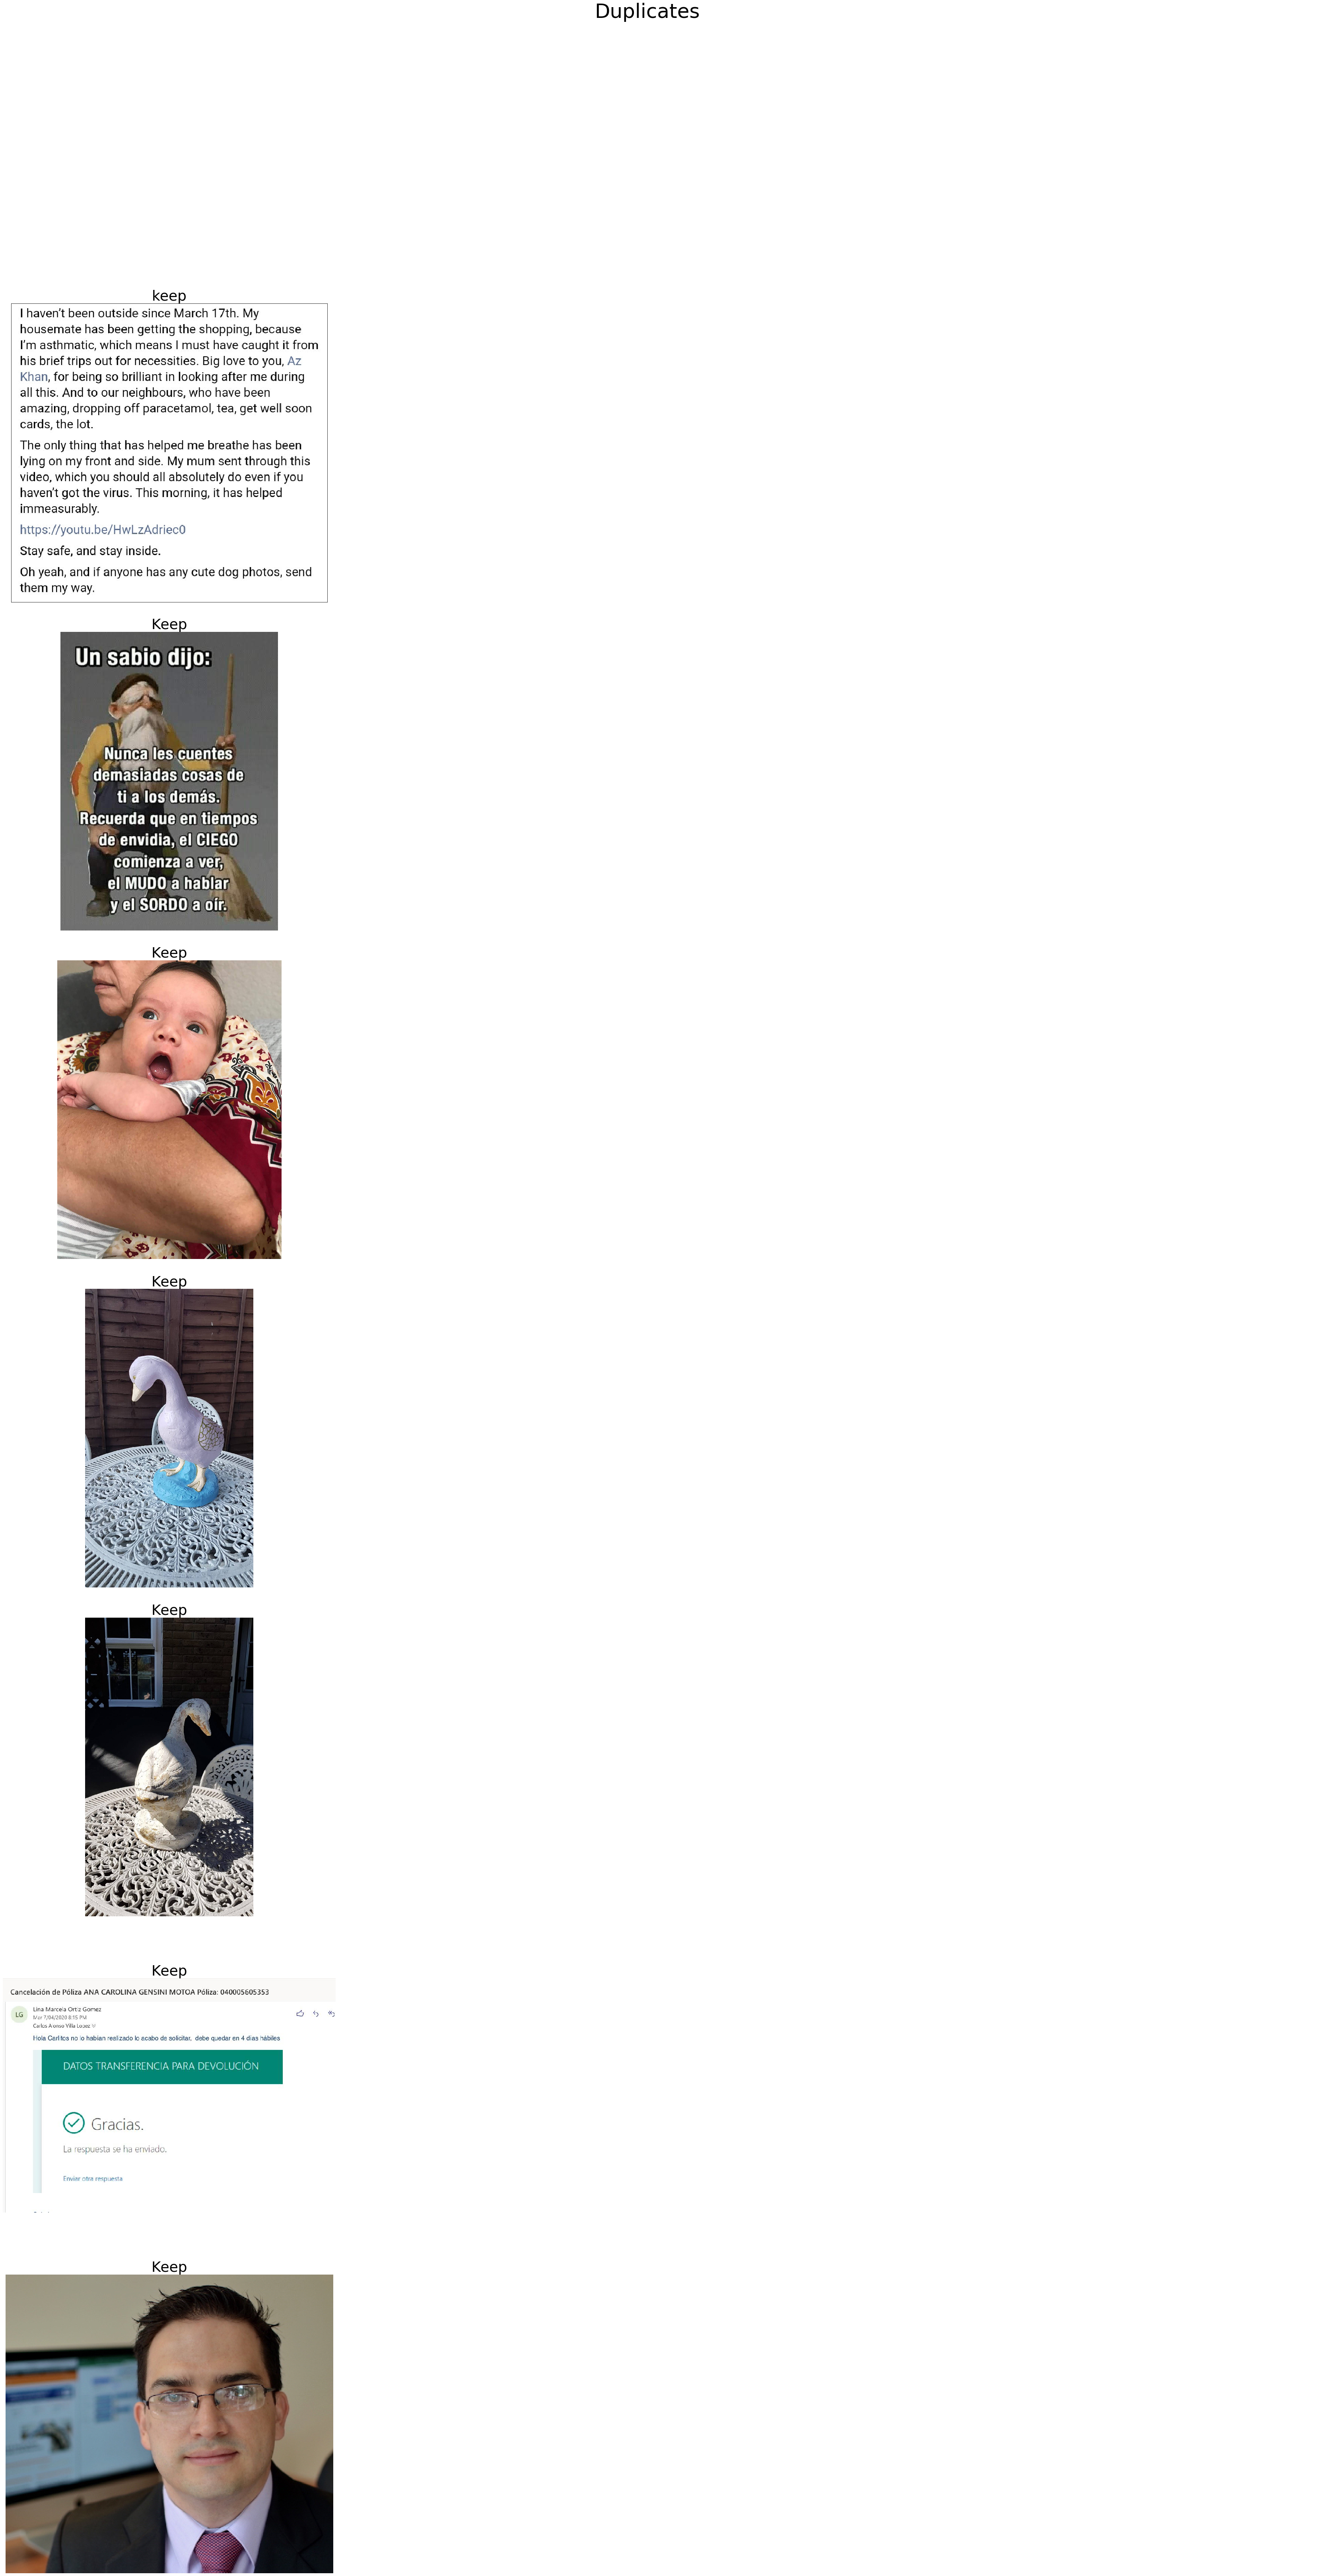

In [28]:
import matplotlib.pyplot as plt, matplotlib.image as mpimg

# Validate if there are repeated files
if pivot_df['count']['All'] ==0:
    # If not repeated files, notify user
    print('No repeated files were found')
else:
    rows = len(reapeated_files_df.index.to_list())
    columns = reapeated_files_df['count'].max()
    fig, axs = plt.subplots(rows,columns, gridspec_kw={'hspace': 0.1, 'wspace': 0})
    fig.set_size_inches((15*columns,15*rows))
    fig.suptitle('Duplicates', fontsize=50)

    for k in range(rows):
        for l in range(columns):
            axs[k,l].axis('off')
            axs[k,l].axes.xaxis.set_ticklabels([])
            axs[k,l].axes.yaxis.set_ticklabels([])
            axs[k,l].axes.xaxis.set_ticks([])
            axs[k,l].axes.yaxis.set_ticks([])

    k=0
    l=0

    image_path = os.path.join(repeated_path_df.index.get_level_values(1)[0])
    img = mpimg.imread(image_path)  
    axs[k,l].imshow(img)
    axs[k,l].axis('on')
    axs[k,l].set_title(repeated_path_df['action'][0], fontsize=36);

    for i in range(1,len(repeated_path_df.index.get_level_values(1).tolist())):
        if repeated_path_df.index.get_level_values(0)[i] == repeated_path_df.index.get_level_values(0)[i-1]:
            # If the hash is the same as the previous row, delete it (Keep only the first one)
            l+=1
        else:
            # if hash changes compared to the last row, keep the file (don't delete it)
            k+=1
            l=0
    
        image_path = os.path.join(repeated_path_df.index.get_level_values(1)[i])
        img = mpimg.imread(image_path)
        axs[k,l].imshow(img)
        axs[k,l].axis('off')
        axs[k,l].set_title(repeated_path_df['action'][i], fontsize=36);


        plt.savefig(now_string + ' - Duplicated' + '.jpg', dpi=300, pad_inches='tight')

In [29]:
txt = input("Do you want to delete the files(Y/N)?: ")

In [30]:
if pivot_df['count']['All'] ==0:
    print('No repeated files were found')

else:
    if txt == 'Y':
        for i in range(0,len(repeated_path_df.index.get_level_values(1).tolist())):
            if repeated_path_df['action'][i] == 'delete':
                os.remove(repeated_path_df.index.get_level_values(1).tolist()[i])
        print('All duplicated images had been deleted')                
    else:
        print('No files were deleted')



No files were deleted
